In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Define IQR function
def iqr(x):
    return np.percentile(x, 75) - np.percentile(x, 25)

In [3]:
Dwell_Exp1 = pd.read_csv("/Volumes/TwoTeras/PCA/Data_Sets/Just_Agents_Exp1.csv")
Dwell_Exp2 = pd.read_csv("/Volumes/TwoTeras/PCA/Data_Sets/Just_Agents_Exp2.csv")

In [4]:
Dwell_Exp1.head()

Unnamed: 0  SubjectID  Session  SessionSubsection  timeStampDataPointEnd  \
0         218        479        2                  1           1.653045e+09   
1         219        479        2                  1           1.653045e+09   
2         220        479        2                  1           1.653045e+09   
3         221        479        2                  1           1.653045e+09   
4         222        479        2                  1           1.653045e+09   

   combinedGazeValidityBitmask  eyePositionCombinedWorld.x  \
0                            3                  -59.137096   
1                            3                  -59.139782   
2                            3                  -59.139782   
3                            3                  -59.139881   
4                            3                  -59.140209   

   eyePositionCombinedWorld.y  eyePositionCombinedWorld.z  \
0                    2.271380                   34.672932   
1                    2.271489                   34.671261   
2                    2.271610                   34.670414   
3                    2.271871                   34.669605   
4                    2.272136                   34.668697   

   eyeDirectionCombinedWorld.y  ...  playerBodyPosition.x  \
0                    -0.014231  ...            -59.099869   
1                    -0.025549  ...            -59.099869   
2                    -0.024258  ...            -59.099869   
3                    -0.009235  ...            -59.099869   
4                    -0.010357  ...            -59.099869   

   playerBodyPosition.y  playerBodyPosition.z  corrected_vel  events  \
0              0.858863             34.795731      12.029048     2.0   
1              0.858863             34.795731       0.047716     NaN   
2              0.858863             34.795731      25.758044     NaN   
3              0.858863             34.795731            NaN     NaN   
4              0.858863             34.795731       0.119112     NaN   

     length  distance  avg_dist  names  Collider_CategoricalN  
0  0.122015  7.238845  7.239133  46_Sa          Passive_Agent  
1  0.122015  7.238177  7.239133  46_Sa          Passive_Agent  
2  0.122015  7.238786  7.239133  46_Sa          Passive_Agent  
3  0.122015  7.239301  7.239133  46_Sa          Passive_Agent  
4  0.122015  7.239728  7.239133  46_Sa          Passive_Agent  

[5 rows x 24 columns]

In [5]:
Proxemics_Session_min = pd.read_csv("/Volumes/TwoTeras/3_Merged_Experiments/Proxemics_Session_Min.csv")
Proxemics_Session_min.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'ped_id',
       'minimal_distance', 'num_interactions', 'SubjectID', 'Session',
       'Agent_Type', 'Experiment', 'PointingTargetBuildingId', 'Agent_ID',
       'BuildingName', 'Context', 'Label'],
      dtype='object')

In [6]:
# Make copies of the filtered fixation DataFrames
Dwell_Exp1_Fixations = Dwell_Exp1[Dwell_Exp1.events == -2].copy()
Dwell_Exp2_Fixations = Dwell_Exp2[Dwell_Exp2.events == -2].copy()

# Now safely add the 'Collider_Type' column
for df in [Dwell_Exp1_Fixations, Dwell_Exp2_Fixations]:
    df.loc[:, "Collider_Type"] = np.where(
        df["Collider_CategoricalN"].str.contains("Face", case=False, na=False),
        "Face",
        "Body"
    )

In [7]:
Proxemics = Proxemics_Session_min[['SubjectID',  'Agent_ID', 'minimal_distance',]].copy()

In [8]:


# Function to summarize and pivot
def summarize_fixations(df):
    grouped = df.groupby(
        ["SubjectID",  "names", "Collider_Type"]
    )[["length", "avg_dist"]].agg({
        "length": ['min', 'max', 'median', 'var', 'std'],
        "avg_dist": ['min', 'max', 'median', 'var', 'std']
    })

    # Flatten columns
    grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]
    grouped = grouped.reset_index()

    # Pivot Collider_Type into column headers
    wide = grouped.pivot_table(
        index=["SubjectID",  "names"],
        columns="Collider_Type"
    )

    # Flatten MultiIndex in columns
    wide.columns = [f"{col[0]}_{col[1]}" for col in wide.columns]
    return wide.reset_index()

# Apply to both datasets
summary_exp1 = summarize_fixations(Dwell_Exp1_Fixations)
summary_exp2 = summarize_fixations(Dwell_Exp2_Fixations)
summary_exp1["Experiment"] = "Exp1"
summary_exp2["Experiment"] = "Exp2"

summary_combined = pd.concat([summary_exp1, summary_exp2], ignore_index=True)
# Extract the numeric part before the underscore in 'names' and convert to integer
summary_combined["Agent_ID"] = summary_combined["names"].str.extract(r"^(\d+)", expand=False).astype(int)

summary_combined.head()

SubjectID   names  avg_dist_max_Body  avg_dist_max_Face  \
0        365  01_Cma          27.792572                NaN   
1        365  02_Cma         144.083030                NaN   
2        365  05_Cma          21.384532                NaN   
3        365  06_Cma          57.922842          18.031457   
4        365  07_Cma          28.804351                NaN   

   avg_dist_median_Body  avg_dist_median_Face  avg_dist_min_Body  \
0             18.933616                   NaN          10.352601   
1             20.313231                   NaN          10.341912   
2             17.664938                   NaN          13.945345   
3             27.173090              3.866642           5.224612   
4             20.486355                   NaN           9.118608   

   avg_dist_min_Face  avg_dist_std_Body  avg_dist_std_Face  ...  \
0                NaN           7.123595                NaN  ...   
1                NaN          39.609295                NaN  ...   
2                NaN           5.260300                NaN  ...   
3           1.770656          12.854549           6.644127  ...   
4                NaN           8.491774                NaN  ...   

   length_median_Body  length_median_Face  length_min_Body  length_min_Face  \
0            0.168639                 NaN         0.121521              NaN   
1            0.336040                 NaN         0.087296              NaN   
2            0.127720                 NaN         0.051585              NaN   
3            0.355136            0.122512         0.044641         0.088287   
4            0.199392                 NaN         0.055056              NaN   

   length_std_Body  length_std_Face  length_var_Body  length_var_Face  \
0         0.101224              NaN         0.010246              NaN   
1         0.363366              NaN         0.132035              NaN   
2         0.107672              NaN         0.011593              NaN   
3         0.247067         0.171075         0.061042         0.029267   
4         0.150184              NaN         0.022555              NaN   

   Experiment  Agent_ID  
0        Exp1         1  
1        Exp1         2  
2        Exp1         5  
3        Exp1         6  
4        Exp1         7  

[5 rows x 24 columns]

In [9]:
# Now merge on common keys
summary_enriched = summary_combined.merge(
    Proxemics,
    on=["SubjectID",  "Agent_ID"],
    how="left"  # or "inner" if you only want matches
)

In [10]:
Entropy = pd.read_csv("/Volumes/TwoTeras/Resources/post_entropy.csv")
# Rename 'ID' to 'SubjectID' for consistency
Entropy = Entropy.rename(columns={"ID": "SubjectID"})

Entropy.head()

Participant_ID         Trial_ID Collider_Name  Occurrence_Order  \
0         0365_1    46_Sa_Trial_1         46_Sa                 1   
1         0365_1   15_Cma_Trial_2        15_Cma                 1   
2         0365_1    51_Sa_Trial_3         51_Sa                 1   
3         0365_1    47_Sa_Trial_9         47_Sa                 1   
4         0365_1  06_Cma_Trial_12        06_Cma                 1   

                    Gaze_Time  Experiment     Building  Building_Effect  \
0  2021-10-29 14:56:02.352618        -0.5  Residential             -0.5   
1  2021-10-29 14:56:29.829516        -0.5       Public              0.5   
2  2021-10-29 14:56:40.572871        -0.5  Residential             -0.5   
3  2021-10-29 14:57:19.963187        -0.5  Residential             -0.5   
4    2021-10-29 14:58:36.8367        -0.5       Public              0.5   

   SubjectID  Session   Agent_Type  Agent_Effect  Match  Event_Index  \
0        365        1  Acontextual          -0.5   -0.5            1   
1        365        1    Congruent           0.5    0.5            2   
2        365        1  Acontextual          -0.5   -0.5            3   
3        365        1  Acontextual          -0.5   -0.5            4   
4        365        1    Congruent           0.5    0.5            5   

       Pre_Post   Entropy  Pre_Post_Effect  
0  Post_Entropy  0.675506              0.5  
1  Post_Entropy  0.736147              0.5  
2  Post_Entropy  0.736813              0.5  
3  Post_Entropy  0.840242              0.5  
4  Post_Entropy  0.819975              0.5

In [11]:
# Step 1: Extract Agent_ID from Collider_Name (e.g., '06_Cma' → 6)
Entropy["Agent_ID"] = Entropy["Collider_Name"].str.extract(r"^(\d+)", expand=False).astype(int)

# Step 2: Filter to only rows where Pre_Post == "Post_Entropy"
post_entropy = Entropy[Entropy["Pre_Post"] == "Post_Entropy"].copy()

# Step 3: Group by and get max Entropy per agent
max_entropy_per_agent = post_entropy.groupby(
    ["SubjectID",  "Agent_ID"]
)["Entropy"].max().reset_index().rename(columns={"Entropy": "Max_Post_Entropy"})


In [12]:
max_entropy_per_agent.head()

SubjectID  Agent_ID  Max_Post_Entropy
0        365         1          0.770602
1        365         2          0.816308
2        365         5          0.747520
3        365         6          0.822855
4        365         7          0.946010

In [13]:
summary_enriched = summary_enriched.merge(
    max_entropy_per_agent,
    on=["SubjectID",  "Agent_ID"],
    how="left"
)


In [14]:
dwell_data = pd.read_csv("/Volumes/TwoTeras/3_Merged_Experiments/Fixations_Dwelling_Sessions.csv")
# Keep only relevant columns
dwell_metrics = dwell_data[[
    "ParticipantID",       # will be renamed to SubjectID
    "recoded",             # will be used to extract Agent_ID
    "Dwelling_Time",
    "Fixation_Count"
]].copy()


In [15]:
dwell_metrics = dwell_metrics.rename(columns={
    "ParticipantID": "SubjectID",
    "recoded": "names"
})
dwell_metrics["Agent_ID"] = dwell_metrics["names"].str.extract(r"^(\d+)", expand=False).astype(int)


In [16]:
summary_enriched = summary_enriched.merge(
    dwell_metrics,
    on=["SubjectID",  "Agent_ID"],
    how="left"
)


In [17]:
summary_enriched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10228 entries, 0 to 10227
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SubjectID             10228 non-null  int64  
 1   names_x               10228 non-null  object 
 2   avg_dist_max_Body     10207 non-null  float64
 3   avg_dist_max_Face     7499 non-null   float64
 4   avg_dist_median_Body  10207 non-null  float64
 5   avg_dist_median_Face  7499 non-null   float64
 6   avg_dist_min_Body     10207 non-null  float64
 7   avg_dist_min_Face     7499 non-null   float64
 8   avg_dist_std_Body     9982 non-null   float64
 9   avg_dist_std_Face     5802 non-null   float64
 10  avg_dist_var_Body     9982 non-null   float64
 11  avg_dist_var_Face     5802 non-null   float64
 12  length_max_Body       10207 non-null  float64
 13  length_max_Face       7499 non-null   float64
 14  length_median_Body    10207 non-null  float64
 15  length_median_Face 

In [18]:
# Drop non-numeric identifier columns
data_for_corr = summary_enriched.drop(columns=["SubjectID",  "Experiment", "names_x","names_y"])

# Compute correlation matrix using pairwise complete observations
correlation_matrix = data_for_corr.corr(method='pearson', min_periods=100)  # adjust min_periods as needed


In [19]:
clean_data = data_for_corr.dropna()
correlation_matrix = clean_data.corr()

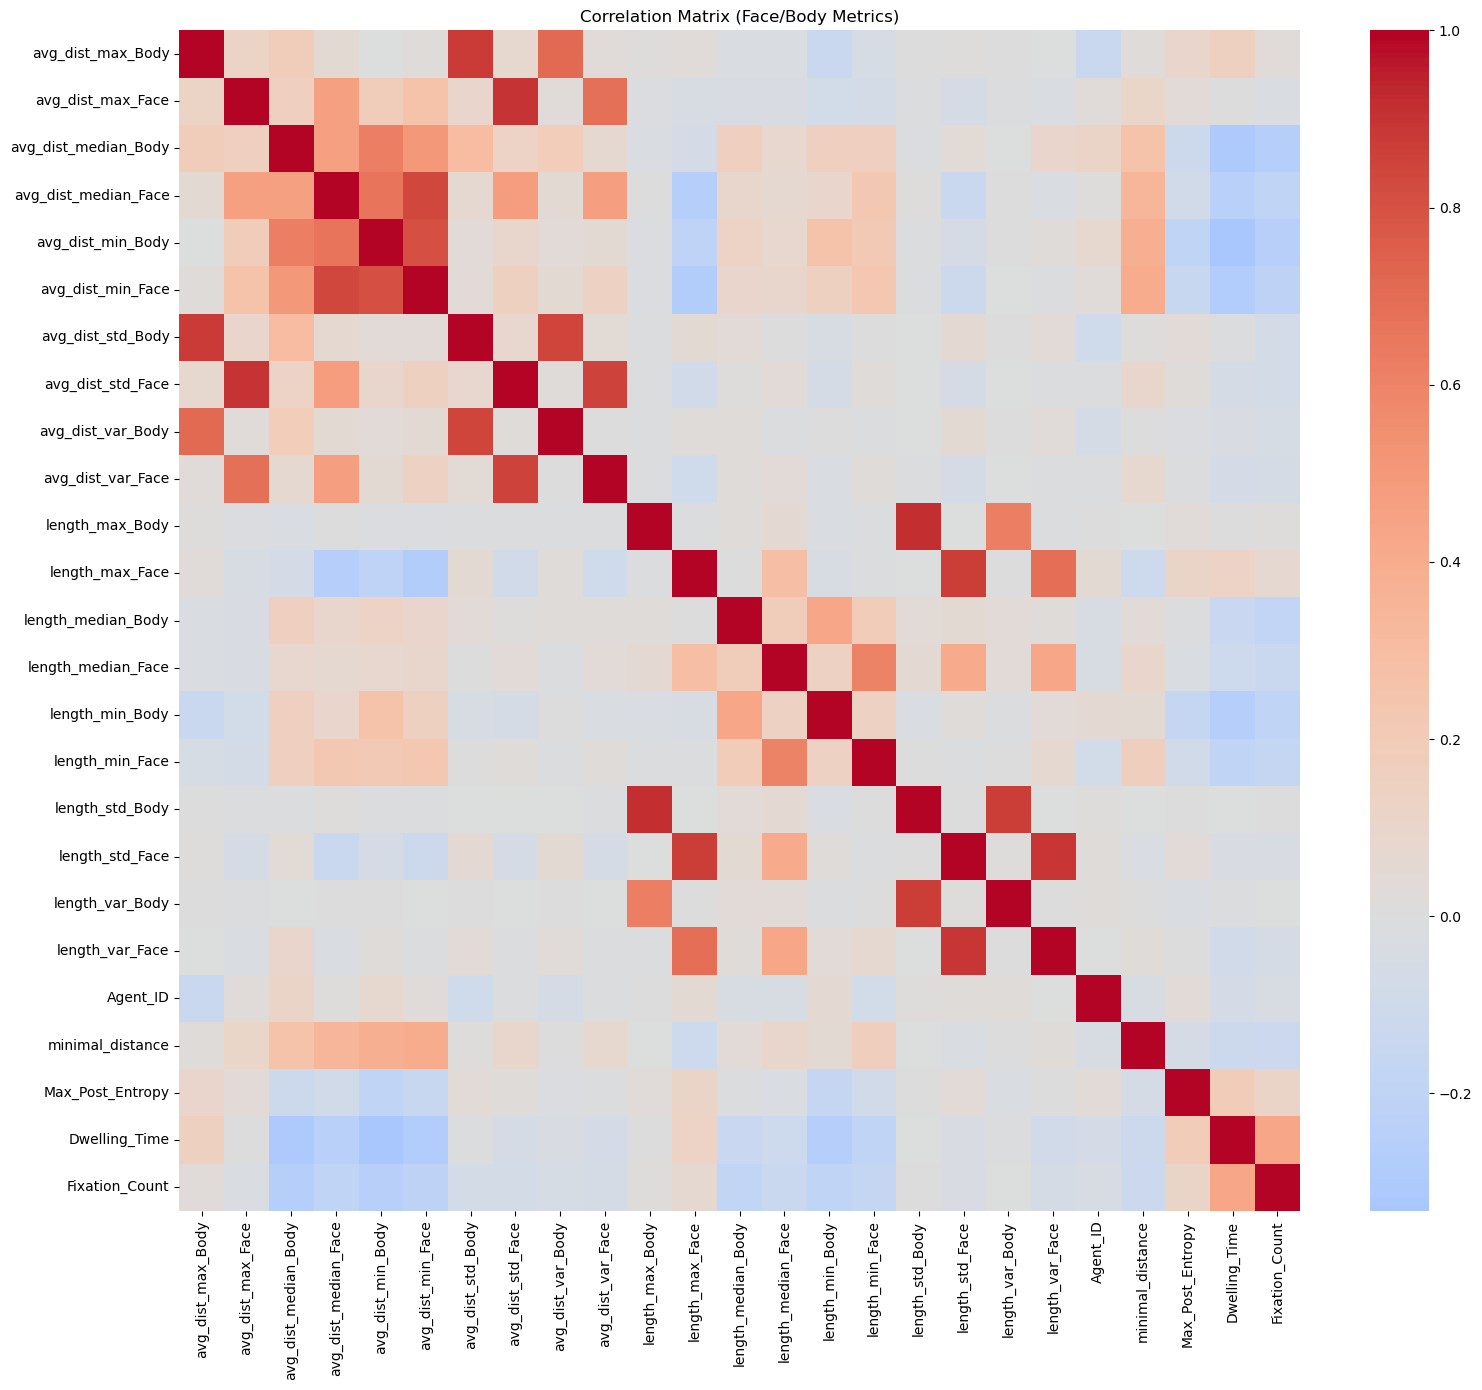

<class 'pandas.core.frame.DataFrame'>
Index: 5052 entries, 8 to 10086
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   avg_dist_max_Body     5052 non-null   float64
 1   avg_dist_max_Face     5052 non-null   float64
 2   avg_dist_median_Body  5052 non-null   float64
 3   avg_dist_median_Face  5052 non-null   float64
 4   avg_dist_min_Body     5052 non-null   float64
 5   avg_dist_min_Face     5052 non-null   float64
 6   avg_dist_std_Body     5052 non-null   float64
 7   avg_dist_std_Face     5052 non-null   float64
 8   avg_dist_var_Body     5052 non-null   float64
 9   avg_dist_var_Face     5052 non-null   float64
 10  length_max_Body       5052 non-null   float64
 11  length_max_Face       5052 non-null   float64
 12  length_median_Body    5052 non-null   float64
 13  length_median_Face    5052 non-null   float64
 14  length_min_Body       5052 non-null   float64
 15  length_min_Face       505

In [20]:
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Matrix (Face/Body Metrics)")
plt.tight_layout()
plt.show()
clean_data.corr()
clean_data.info()

In [21]:
# Count non-NaN values per column
non_nan_counts = summary_enriched.notna().sum()

# Sort columns by non-NaN count (descending)
sorted_columns = non_nan_counts.sort_values(ascending=False).index

# Reorder DataFrame columns
summary_enriched_sorted = summary_enriched[sorted_columns]
summary_enriched_sorted.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10228 entries, 0 to 10227
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SubjectID             10228 non-null  int64  
 1   names_x               10228 non-null  object 
 2   Max_Post_Entropy      10228 non-null  float64
 3   Agent_ID              10228 non-null  int64  
 4   Experiment            10228 non-null  object 
 5   Dwelling_Time         10208 non-null  float64
 6   names_y               10208 non-null  object 
 7   Fixation_Count        10208 non-null  float64
 8   length_median_Body    10207 non-null  float64
 9   length_min_Body       10207 non-null  float64
 10  avg_dist_max_Body     10207 non-null  float64
 11  avg_dist_median_Body  10207 non-null  float64
 12  length_max_Body       10207 non-null  float64
 13  avg_dist_min_Body     10207 non-null  float64
 14  length_var_Body       9984 non-null   float64
 15  length_std_Body    

In [22]:

# --- 1. Drop irrelevant columns ---
drop_cols = ['SubjectID',  'names_x', 'names_y', 'Experiment', 'Agent_ID']
df_clean = summary_enriched.drop(columns=drop_cols)

# --- 2. Keep only numeric columns (optional: include minimal_distance etc.) ---
numeric_df = df_clean.select_dtypes(include=['float64', 'int64'])

# --- 3. Drop rows with too many missing values (optional threshold) ---
row_thresh = 0.85 * numeric_df.shape[1]  # keep rows with at least 85% non-null
numeric_df = numeric_df.dropna(thresh=row_thresh)

# --- 4. Fill remaining missing values with column means ---
numeric_df = numeric_df.fillna(numeric_df.mean())

# --- 5. Standardize the data ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_df)

# --- 6. Run PCA (keep 3 components for 3D plot) ---
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)



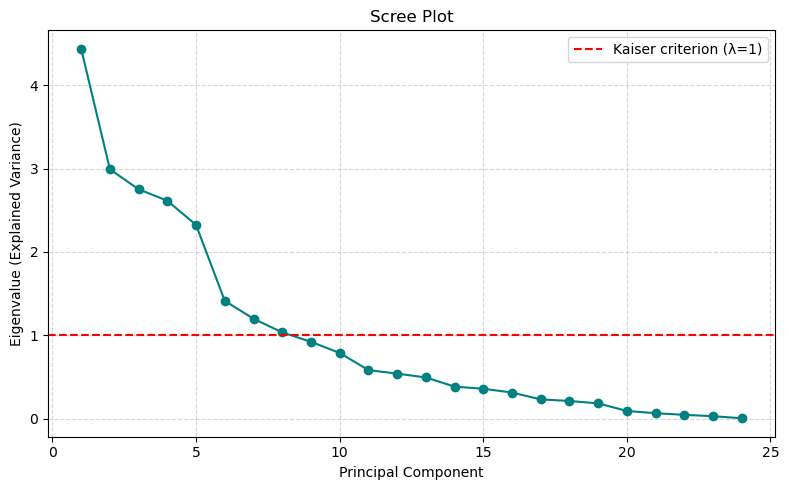

In [23]:


# Fit PCA to full number of components
pca_full = PCA().fit(X_scaled)

# Plot the scree plot
plt.figure(figsize=(8, 5))
plt.plot(
    np.arange(1, len(pca_full.explained_variance_)+1),
    pca_full.explained_variance_,
    marker='o', linestyle='-', color='teal'
)

plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue (Explained Variance)')
plt.title('Scree Plot')
plt.axhline(y=1, color='red', linestyle='--', label='Kaiser criterion (λ=1)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [24]:
# Components with eigenvalue > 1
n_kaiser = sum(pca_full.explained_variance_ > 1)
print(f"Components with eigenvalue > 1 (Kaiser criterion): {n_kaiser}")


Components with eigenvalue > 1 (Kaiser criterion): 8


In [1]:
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Components needed to explain 90% of variance: {n_components_90}")


NameError: name 'np' is not defined

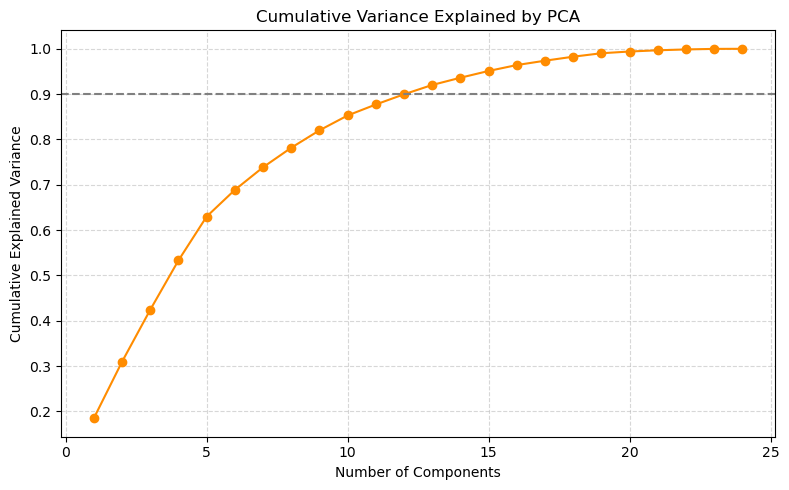

In [26]:
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(cumulative_variance)+1), cumulative_variance, marker='o', color='darkorange')
plt.axhline(y=0.90, color='gray', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Variance Explained by PCA')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


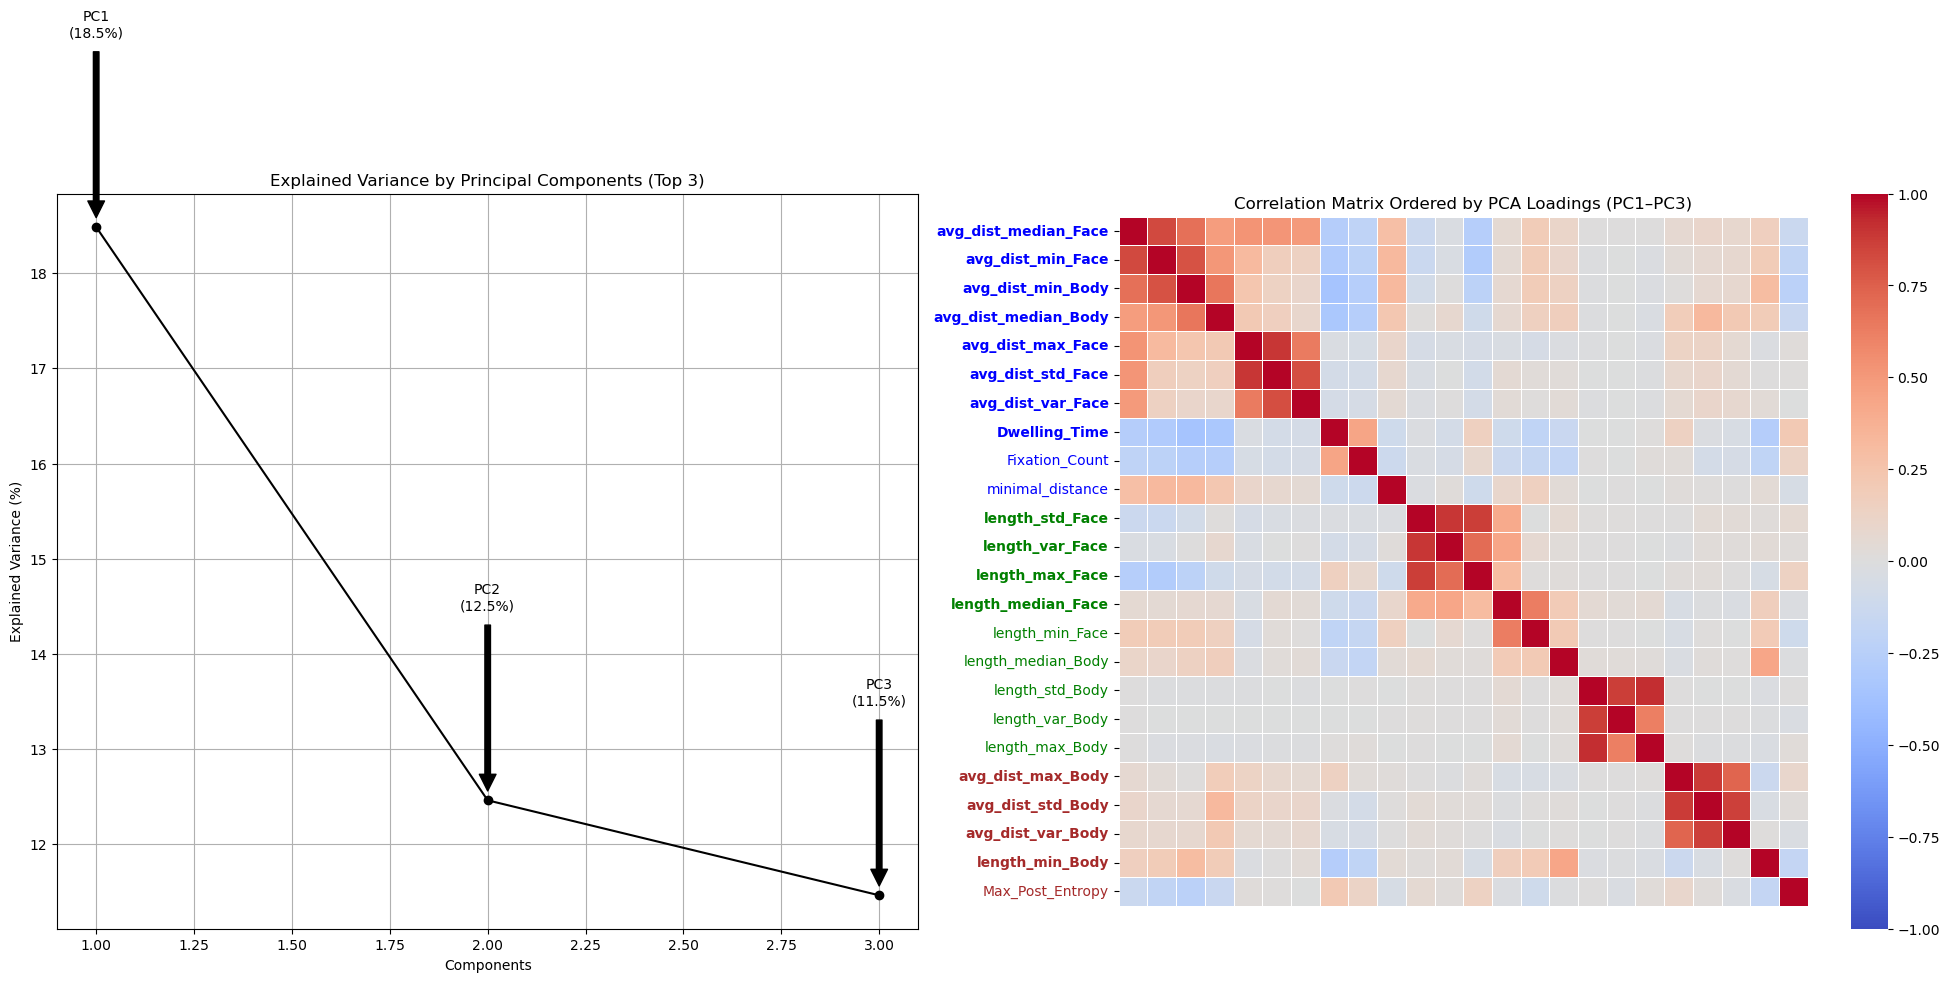

In [27]:
stats_df = numeric_df.copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(stats_df)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Reconstruct loadings using the earlier PCA
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(3)], index=numeric_df.columns)

# Use numeric_df as the data to compute correlations
stats_df = numeric_df.copy()

# Compute explained variance
explained_variance = pca.explained_variance_ratio_ * 100
components = np.arange(1, 4)  # Only 3 components computed

# Assign each feature to the PC with the highest absolute loading
feature_to_pc = loadings[['PC1', 'PC2', 'PC3']].abs().idxmax(axis=1)

# Assign color based on dominant PC
def get_feature_color(feature):
    max_pc = feature_to_pc[feature]
    return {'PC1': 'blue', 'PC2': 'green', 'PC3': 'brown'}.get(max_pc, 'black')

# Assign font weight based on absolute loading > 0.2
def get_fontweight(feature):
    max_loading = loadings.loc[feature, ['PC1', 'PC2', 'PC3']].abs().max()
    return 'bold' if max_loading > 0.2 else 'normal'

# Order features by loadings from PC1 to PC3
ordered_features_by_pc = {
    'PC1': loadings.loc[feature_to_pc == 'PC1', 'PC1'].abs().sort_values(ascending=False).index.tolist(),
    'PC2': loadings.loc[feature_to_pc == 'PC2', 'PC2'].abs().sort_values(ascending=False).index.tolist(),
    'PC3': loadings.loc[feature_to_pc == 'PC3', 'PC3'].abs().sort_values(ascending=False).index.tolist()
}

# Combine all features in order
ordered_features = ordered_features_by_pc['PC1'] + ordered_features_by_pc['PC2'] + ordered_features_by_pc['PC3']
ordered_features += [f for f in loadings.index if f not in ordered_features]  # add any remaining

# Correlation matrix
corr_matrix = stats_df.corr()
ordered_corr_matrix = corr_matrix.loc[ordered_features, ordered_features]

# Colors and font weights
feature_colors = [get_feature_color(f) for f in ordered_corr_matrix.columns]
font_weights = [get_fontweight(f) for f in ordered_corr_matrix.columns]

# Plot
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Scree plot
axs[0].plot(components, explained_variance[:3], 'o-', color='black')
axs[0].set_xlabel('Components')
axs[0].set_ylabel('Explained Variance (%)')
axs[0].set_title('Explained Variance by Principal Components (Top 3)')
axs[0].grid(True)

# Annotate top 3 PCs
for i, component in enumerate(['PC1', 'PC2', 'PC3']):
    x = i + 1
    y = explained_variance[i]
    axs[0].annotate(f'{component}\n({y:.1f}%)', xy=(x, y), xytext=(x, y + 2),
                    arrowprops=dict(facecolor='black', shrink=0.05), ha='center')

# Correlation heatmap
sns.heatmap(
    ordered_corr_matrix,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    ax=axs[1],
    xticklabels=False,
    yticklabels=True,
    cbar=True,
    square=True,
    linewidths=0.5
)

# Apply color and fontweight to y-axis tick labels
ax = axs[1]
for ticklabel, color, weight in zip(ax.get_yticklabels(), feature_colors, font_weights):
    ticklabel.set_color(color)
    ticklabel.set_fontweight(weight)
    ticklabel.set_rotation(0)

axs[1].set_title('Correlation Matrix Ordered by PCA Loadings (PC1–PC3)')

plt.tight_layout()
plt.show()

In [28]:
# Feature names (columns that were used for PCA)
feature_names = numeric_df.columns

# Loadings (components_ is a matrix: PC × original feature)
loadings = pd.DataFrame(
    pca.components_.T,  # transpose to get features × PCs
    columns=['PC1', 'PC2', 'PC3'],
    index=feature_names
)


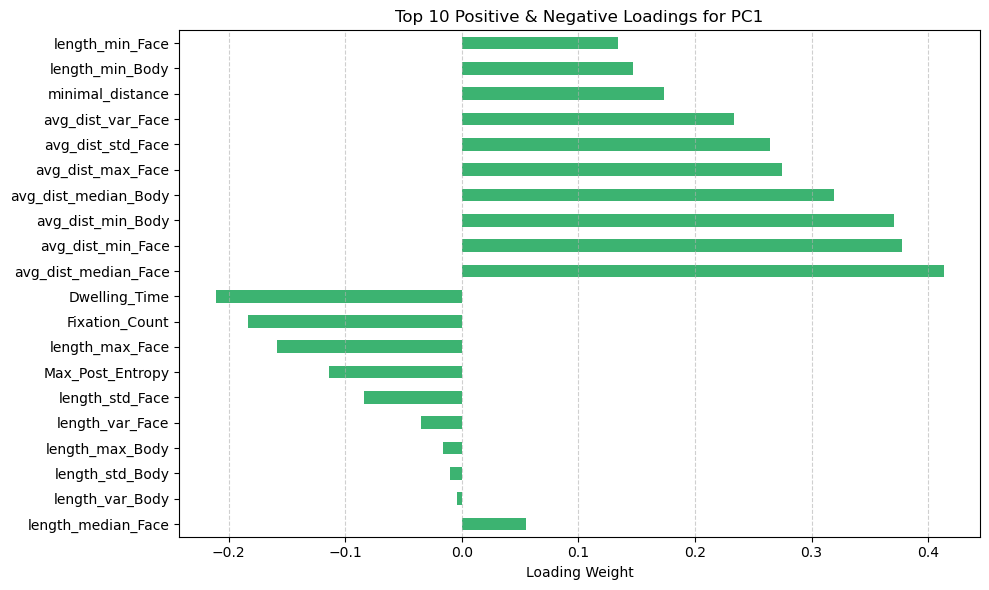

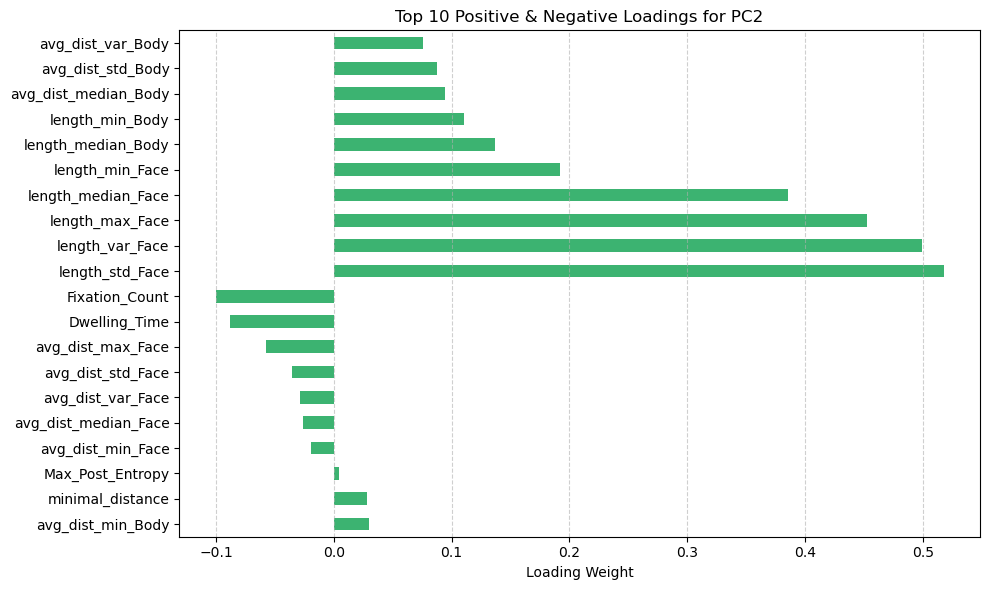

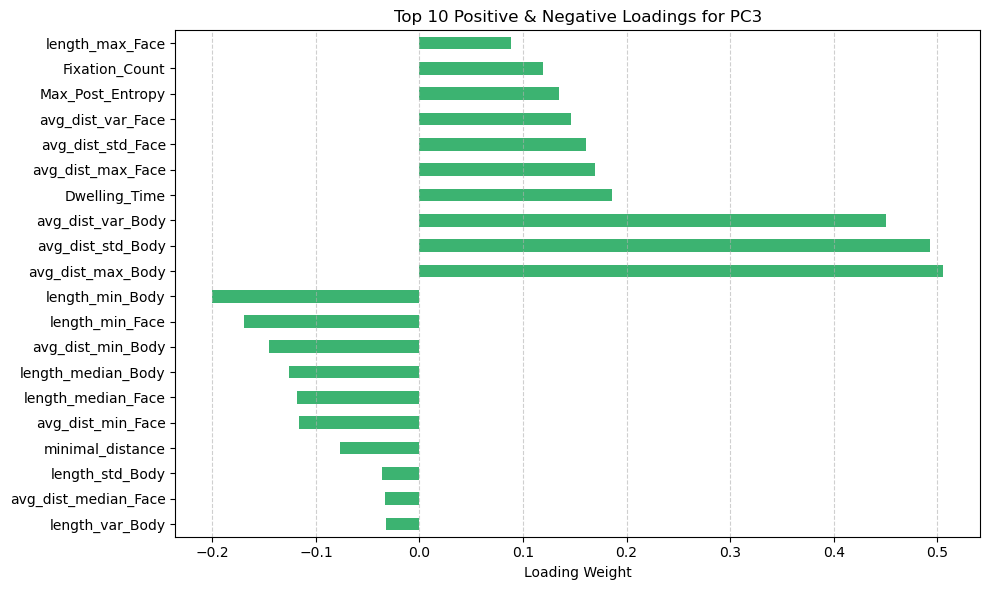

In [29]:
import matplotlib.pyplot as plt

def plot_loadings(loadings, pc='PC1', top_n=10):
    sorted_loadings = loadings[pc].sort_values(ascending=False)
    
    top_features = sorted_loadings[:top_n]
    bottom_features = sorted_loadings[-top_n:]
    
    combined = pd.concat([bottom_features, top_features])
    
    plt.figure(figsize=(10, 6))
    combined.plot(kind='barh', color='mediumseagreen')
    plt.title(f'Top {top_n} Positive & Negative Loadings for {pc}')
    plt.xlabel('Loading Weight')
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_loadings(loadings, pc='PC1', top_n=10)
plot_loadings(loadings, pc='PC2', top_n=10)
plot_loadings(loadings, pc='PC3', top_n=10)


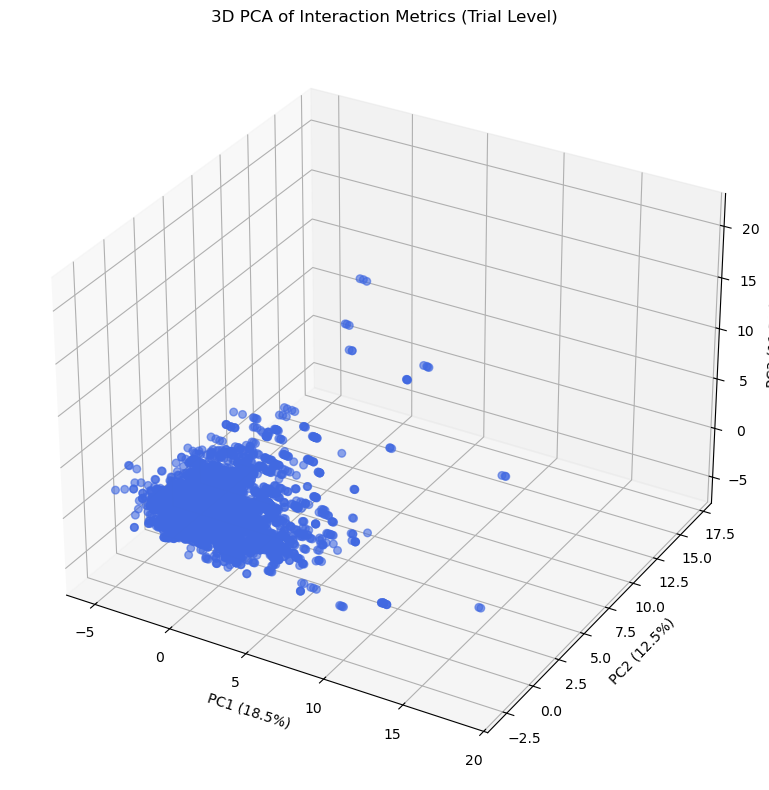

In [30]:
# --- 7. Plot the 3D PCA ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c='royalblue', alpha=0.6, s=30)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)')
ax.set_title('3D PCA of Interaction Metrics (Trial Level)')

plt.tight_layout()
plt.show()

